In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import shutil
import zipfile

In [4]:
project_path = '/content/drive/MyDrive/Master/Dizertatie'
os.chdir(project_path)

print("Current directory:", os.getcwd())


Current directory: /content/drive/MyDrive/Master/Dizertatie


In [5]:
sys.path.append(os.path.join(project_path, 'utils'))

In [6]:
dataset_folder = '/content/drive/MyDrive/Master/Dizertatie/BCN20000'
os.listdir(dataset_folder)

['bcn20000_metadata_2024-12-04.csv',
 'ISIC-images',
 '.ipynb_checkpoints',
 'split-dataset',
 'resized-images',
 'augmented-train-images-aug2',
 'augmented_train_images_aug3',
 'resized-images-224',
 'augmented-train-images-aug4',
 'split-dataset-224',
 'train',
 'no-background']

In [7]:
from importlib import reload
import plots
reload(plots)
import preprocessing
reload(preprocessing)
import data_augmentation
reload(data_augmentation)
import model
reload(model)


<module 'model' from '/content/drive/MyDrive/Master/Dizertatie/utils/model.py'>

In [8]:
from plots import (
    plot_class_distribution,
    plot_diagnosis_distribution,
    plot_age_distribution,
    plot_gender_proportion,
    plot_anatomical_site_distribution,
    plot_example_images_per_class
)
from preprocessing import (
    crop_and_save_image,
    crop_images_in_folder,
    resize_images,
    split_train_test
)
from data_augmentation import (
    augment_images
)
from model import (
    create_feature_vector,
    process_images,
    create_efficientnet,
    create_metadata_network,
    create_combined_model,
    train_model
)

In [9]:
train_zip_path = "/content/drive/MyDrive/Master/Dizertatie/cropped-train-224.zip"
test_zip_path = "/content/drive/MyDrive/Master/Dizertatie/cropped-test-224.zip"
metadata_path = "/content/drive/MyDrive/Master/Dizertatie/BCN20000/bcn20000_metadata_2024-12-04.csv"

local_train_zip_path = "/content/dataset.zip"
local_test_zip_path = "/content/test.zip"
local_metadata_path = "/content/metadata.csv"

shutil.copy(train_zip_path, local_train_zip_path)
shutil.copy(test_zip_path, local_test_zip_path)
shutil.copy(metadata_path, local_metadata_path)
print(f"The file was copied locally: {local_train_zip_path}")
print(f"The file was copied locally: {local_test_zip_path}")
print(f"The file was copied locally: {local_metadata_path}")


The file was copied locally: /content/dataset.zip
The file was copied locally: /content/test.zip
The file was copied locally: /content/metadata.csv


In [10]:
extract_folder_train = "/content/dataset/"
extract_folder_test = "/content/test/"

os.makedirs(extract_folder_train, exist_ok=True)
os.makedirs(extract_folder_test, exist_ok=True)

with zipfile.ZipFile(local_train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_train)
with zipfile.ZipFile(local_test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_test)

print(f"Files were added to: {extract_folder_train}")
print(f"Files were added to: {extract_folder_test}")


Files were added to: /content/dataset/
Files were added to: /content/test/


In [11]:
train_image_folder = extract_folder_train + 'cropped-train-224/'
test_image_folder = extract_folder_test + 'cropped-test-224/'

In [12]:
# Load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())


        isic_id                   attribution copyright_license  age_approx  \
0  ISIC_0053453  Hospital Clínic de Barcelona          CC-BY-NC        60.0   
1  ISIC_0053454  Hospital Clínic de Barcelona          CC-BY-NC        55.0   
2  ISIC_0053455  Hospital Clínic de Barcelona          CC-BY-NC        50.0   
3  ISIC_0053456  Hospital Clínic de Barcelona          CC-BY-NC        50.0   
4  ISIC_0053457  Hospital Clínic de Barcelona          CC-BY-NC        85.0   

  anatom_site_general benign_malignant  concomitant_biopsy  \
0      anterior torso           benign                True   
1      anterior torso        malignant                True   
2     lower extremity              NaN                True   
3      anterior torso        malignant                True   
4           head/neck              NaN                True   

                 diagnosis diagnosis_1  \
0                    nevus      Benign   
1                 melanoma   Malignant   
2                    other

In [13]:
combination_counts = pd.crosstab(metadata['diagnosis'], metadata['diagnosis_1'])
print(combination_counts)


diagnosis_1              Benign  Indeterminate  Malignant
diagnosis                                                
actinic keratosis             0           1088          0
basal cell carcinoma          0              0       3676
dermatofibroma              168              0          0
melanoma                      0              0       4003
melanoma metastasis           0              0        633
nevus                      5647              0          0
scar                        314              0          0
seborrheic keratosis       1268              0          0
solar lentigo               283              0          0
squamous cell carcinoma       0              0        559
vascular lesion             151              0          0


In [14]:
metadata['diagnosis'].value_counts()

,count
diagnosis,
nevus,5647
melanoma,4003
basal cell carcinoma,3676
seborrheic keratosis,1268
other,1156
actinic keratosis,1088
melanoma metastasis,633
squamous cell carcinoma,559
scar,314


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from collections import Counter
from PIL import Image
import shutil
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
import random

def create_label_dict(metadata, diagnosis_mapping, image_folder):
    """
    Creates a dictionary mapping image filenames to labels

    Parameters:
    - metadata (pd.DataFrame):DataFrame containing 'isic_id' and 'diagnosis'.
    - diagnosis_mapping (dict): dictionary with the diagnosis
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: class}
    """
    label_dict = {}

    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            isic_id = file[:12]
            diagnosis = metadata.loc[metadata['isic_id'] == isic_id, 'diagnosis']

            if not diagnosis.empty:
                label_dict[file] = diagnosis_mapping[diagnosis.values[0]]

    return label_dict


def create_diagnosis_mapping(metadata):
    """
    Creates a mapping from diagnosis to numerical labels.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'diagnosis'.

    Returns:
    - dict: Mapping of diagnosis to numerical labels.
    """
    return {diag: idx for idx, diag in enumerate(metadata['diagnosis'].unique())}

def calculate_class_distribution(metadata, folder, diagnosis_mapping):
    """
    Calculates the class distribution in the training dataset.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'isic_id' and 'diagnosis'.
    - folder: Name of folder with the location of the images
    - diagnosis_mapping (dict): Mapping of diagnosis to numerical labels.

    Returns:
    - dict: Class distribution in the dataset.
    """
    image_ids = [os.path.splitext(f)[0] for f in os.listdir(folder) if f.endswith('.jpg')]
    prefixes = [img_id[:12] for img_id in image_ids]

    labels = []
    for prefix in prefixes:
        diagnosis = metadata.loc[metadata['isic_id'] == prefix, 'diagnosis'].map(diagnosis_mapping).values
        if len(diagnosis) > 0:
            labels.append(diagnosis[0])

    return Counter(labels)


def create_image_generator(image_folder, label_dict, num_classes, batch_size=32, target_size=(224, 224)):
    """
    Creates a generator for images, labels, and sample weights.
    """
    image_files = [f for f in os.listdir(image_folder) if f in label_dict]

    while True:
        random.shuffle(image_files) 

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            images, labels = [], []

            for file in batch_files:
                img_path = os.path.join(image_folder, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img).astype('float32') / 255.0  # Normalize image

                label = label_dict[file]

                images.append(img_array)
                labels.append(label)

            images = np.array(images)
            labels = to_categorical(labels, num_classes=num_classes)

            yield images, labels




def create_efficientnet(input_shape=(224, 224, 3), num_classes=10):
    """
    Creates an EfficientNet model for image classification.

    Parameters:
    - input_shape (tuple): Shape of the input image.
    - num_classes (int): Number of output classes.

    Returns:
    - Compiled Keras model.
    """
    image_input = Input(shape=input_shape)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, test_generator, train_steps, test_steps, epochs=20):
    """
    Trains the model using the provided generators, including sample weights.

    Parameters:
    - model (Model): The Keras model to train.
    - train_generator (generator): Generator for training data.
    - test_generator (generator): Generator for validation data.
    - train_steps (int): Number of steps per epoch for training.
    - test_steps (int): Number of steps per epoch for validation.
    - epochs (int): Number of epochs.

    Returns:
    - History object from the training process.
    """

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-7
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        validation_data=test_generator,
        validation_steps=test_steps,
        epochs=epochs,
        callbacks=[lr_scheduler]
    )
    return history


In [ ]:
metadata = pd.read_csv(metadata_path)

diagnosis_mapping = create_diagnosis_mapping(metadata)
train_labels = create_label_dict(metadata, diagnosis_mapping, train_image_folder)
test_labels = create_label_dict(metadata, diagnosis_mapping, test_image_folder)

In [17]:
len(os.listdir(train_image_folder))

14209

In [18]:
diagnosis_mapping

{'nevus': 0,
 'melanoma': 1,
 'other': 2,
 'squamous cell carcinoma': 3,
 'solar lentigo': 4,
 'basal cell carcinoma': 5,
 'melanoma metastasis': 6,
 'seborrheic keratosis': 7,
 'actinic keratosis': 8,
 'dermatofibroma': 9,
 'scar': 10,
 'vascular lesion': 11}

In [19]:
from collections import Counter

class_distribution = Counter(train_labels.values())

for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} images")

Class 1: 2983 images
Class 0: 4200 images
Class 5: 2791 images
Class 6: 469 images
Class 7: 960 images
Class 4: 193 images
Class 2: 899 images
Class 8: 816 images
Class 10: 241 images
Class 3: 407 images
Class 11: 121 images
Class 9: 129 images


In [20]:
from collections import Counter

class_distribution_test = Counter(test_labels.values())

for cls, count in class_distribution_test.items():
    print(f"Class {cls}: {count} images")

Class 2: 257 images
Class 0: 1447 images
Class 1: 1020 images
Class 9: 39 images
Class 6: 164 images
Class 3: 152 images
Class 11: 30 images
Class 7: 308 images
Class 5: 885 images
Class 8: 272 images
Class 4: 90 images
Class 10: 73 images


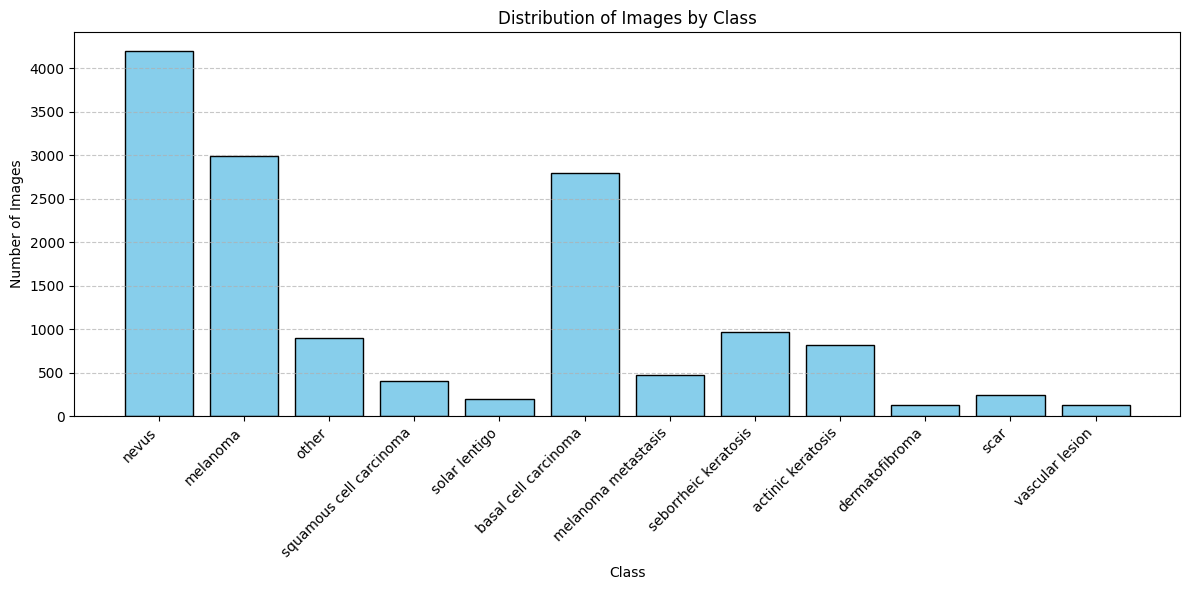

In [ ]:
# Reverse the diagnosis_mapping to get class names by index
reversed_mapping = {v: k for k, v in diagnosis_mapping.items()}

sorted_classes = sorted(class_distribution.keys())
sorted_counts = [class_distribution[cls] for cls in sorted_classes]
sorted_labels = [reversed_mapping[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
train_files = set(os.listdir(train_image_folder))
val_files = set(os.listdir(test_image_folder))

overlap = train_files.intersection(val_files)
print(f"Overlapping images: {len(overlap)}")  


Overlapping images: 0


In [ ]:
train_generator = create_image_generator(train_image_folder, train_labels, num_classes=len(diagnosis_mapping), batch_size=32, target_size=(224, 224))
test_generator = create_image_generator(test_image_folder, test_labels, num_classes=len(diagnosis_mapping), batch_size=32, target_size=(224, 224))

model = create_efficientnet(input_shape=(224, 224, 3), num_classes=len(diagnosis_mapping))


history = train_model(
    model=model,
    train_generator=train_generator,
    test_generator=test_generator,
    train_steps=len(os.listdir(train_image_folder)) // 32,
    test_steps=len(os.listdir(test_image_folder)) // 32,
    epochs=20
)


Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 179s 170ms/step - accuracy: 0.4879 - loss: 1.5690 - val_accuracy: 0.3055 - val_loss: 2.4309 - learning_rate: 0.0010
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 137s 238ms/step - accuracy: 0.6050 - loss: 1.1696 - val_accuracy: 0.2912 - val_loss: 2.6984 - learning_rate: 0.0010
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6687 - loss: 0.9769 - val_accuracy: 0.3045 - val_loss: 2.0595 - learning_rate: 0.0010
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 70s 157ms/step - accuracy: 0.7341 - loss: 0.7645 - val_accuracy: 0.2147 - val_loss: 23.5695 - learning_rate: 0.0010
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7936 - loss: 0.5989
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
444/444 ━━━━━━━━━━━━━━━━━━━━ 78s 176ms/step - accuracy: 0.7936 - loss: 0.5989 - val_accuracy: 0.2153 - val_loss: 152.5147 - learning_rate: 0.0010
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 67s 152ms/step - accuracy: 

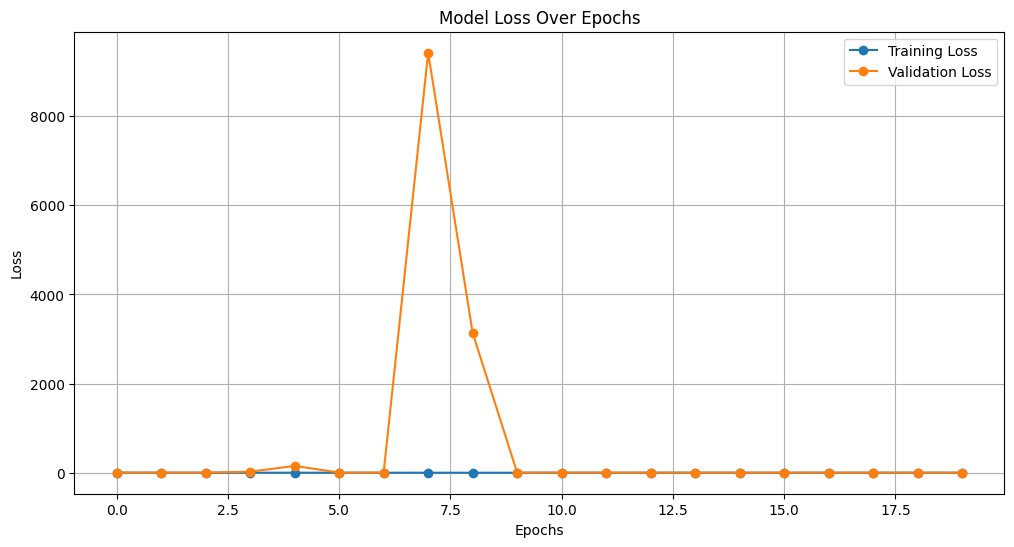

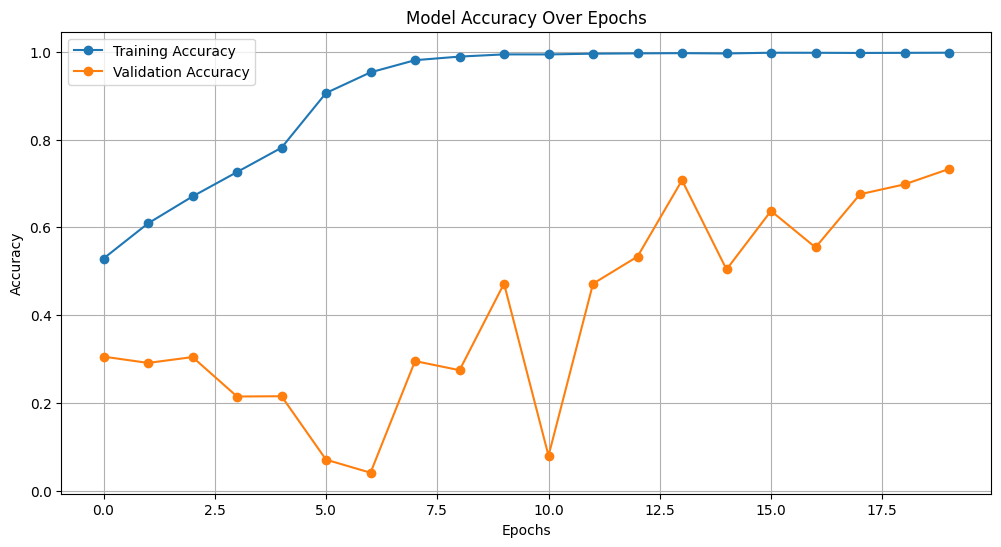

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
import numpy as np

# Get predictions and true labels
y_true = []
y_pred = []

for _ in range(len(os.listdir(test_image_folder)) // 32):
    images, labels = next(test_generator)
    predictions = model.predict(images)

    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━

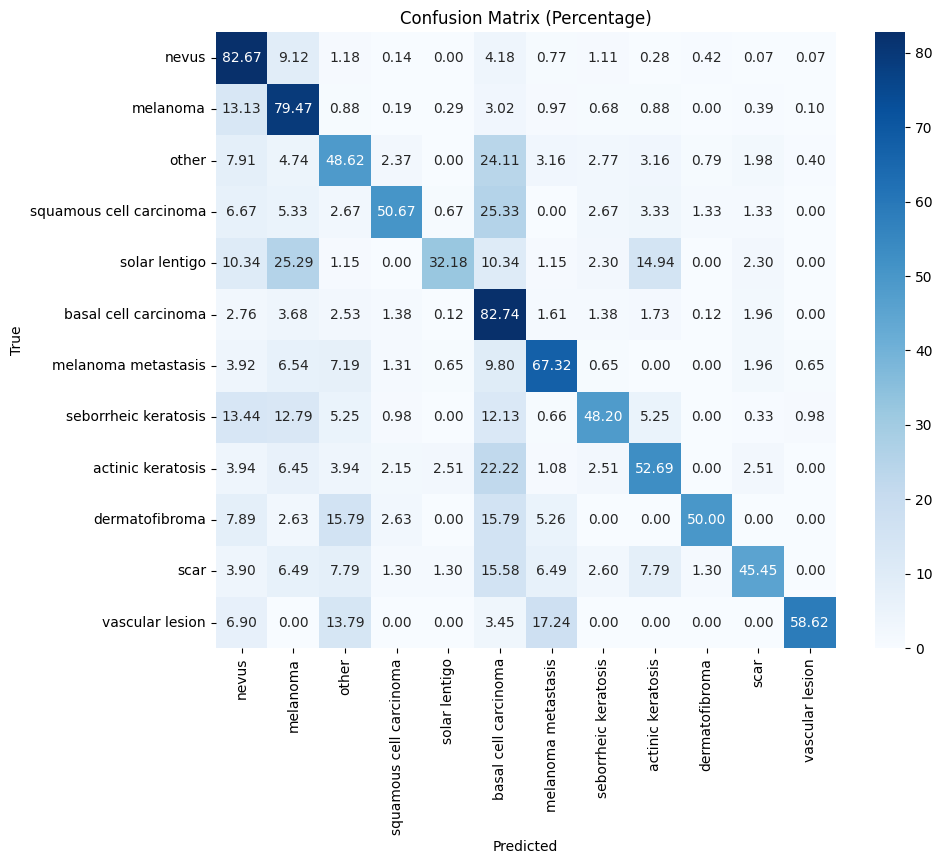

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent * 100, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=diagnosis_mapping.keys(), yticklabels=diagnosis_mapping.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()


In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred, target_names=diagnosis_mapping.keys(), output_dict=True)

print("Class-wise Accuracy, Precision, Recall, and F1-Score:")
for class_name, metrics in class_report.items():
    if class_name not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"\nClass: {class_name}")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-Score: {metrics['f1-score']:.2f}")


Class-wise Accuracy, Precision, Recall, and F1-Score:

Class: nevus
  Precision: 0.82
  Recall: 0.83
  F1-Score: 0.82

Class: melanoma
  Precision: 0.75
  Recall: 0.79
  F1-Score: 0.77

Class: other
  Precision: 0.53
  Recall: 0.49
  F1-Score: 0.51

Class: squamous cell carcinoma
  Precision: 0.68
  Recall: 0.51
  F1-Score: 0.58

Class: solar lentigo
  Precision: 0.67
  Recall: 0.32
  F1-Score: 0.43

Class: basal cell carcinoma
  Precision: 0.68
  Recall: 0.83
  F1-Score: 0.75

Class: melanoma metastasis
  Precision: 0.63
  Recall: 0.67
  F1-Score: 0.65

Class: seborrheic keratosis
  Precision: 0.72
  Recall: 0.48
  F1-Score: 0.58

Class: actinic keratosis
  Precision: 0.66
  Recall: 0.53
  F1-Score: 0.59

Class: dermatofibroma
  Precision: 0.61
  Recall: 0.50
  F1-Score: 0.55

Class: scar
  Precision: 0.45
  Recall: 0.45
  F1-Score: 0.45

Class: vascular lesion
  Precision: 0.71
  Recall: 0.59
  F1-Score: 0.64


In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)

class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Accuracy per class:")
for idx, class_name in enumerate(diagnosis_mapping.keys()):
    print(f"{class_name}: {class_accuracies[idx]:.2f}")


Accuracy per class:
nevus: 0.83
melanoma: 0.79
other: 0.49
squamous cell carcinoma: 0.51
solar lentigo: 0.32
basal cell carcinoma: 0.83
melanoma metastasis: 0.67
seborrheic keratosis: 0.48
actinic keratosis: 0.53
dermatofibroma: 0.50
scar: 0.45
vascular lesion: 0.59


In [55]:
model.save('/content/drive/MyDrive/Master/Dizertatie/model-cropped-224-no-aug.h5')
